In [1]:
from sklearn.metrics import mean_absolute_error as MAE
from sklearn import cross_validation, grid_search, metrics, ensemble

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np

import os
if not os.path.isdir('stack'):
    os.mkdir('stack')

/home/dada/.local/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/dada/.local/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
import pandas as pd
ttt = pd.read_csv('merge.csv')
ttt.head()

,Book-Rating,ISBN,User-ID,age,loc,author,years,publisher
0,8.0,1550372289,153d612c88,47.0,"toronto, ontario, canada",Michael Kusugak,1992.0,Annick Press
1,10.0,030796017X,f73f18a13a,NaN,"lake wales, florida, usa",MERCER MAYER,2001.0,Golden Books
2,8.0,014028009,02e87fe603,29.0,"delft, zuid holland, netherlands",NaN,NaN,NaN
3,10.0,0345413350,be36e5b8cb,NaN,"rochester, new york, usa",PHILIP PULLMAN,1997.0,Del Rey
4,9.0,0609600788,98ec1c54b5,45.0,"hummelstown, pennsylvania, usa",DEEPAK CHOPRA,2000.0,Harmony


In [3]:
traindf, testdf = pd.read_csv('./data/book_ratings_train.csv'), pd.read_csv('./data/book_ratings_test.csv')
print ('traindf', len(traindf))
print ('testdf', len(testdf))
train = ttt[:len(traindf)]
test = ttt[len(traindf):]

traindf 260202
testdf 173469


In [4]:
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import scale

def fill_nan(inp):
    imp = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
    tv = imp.fit_transform(inp.reshape(-1, 1))
    tv = tv.reshape(-1)
    tvc = scale(tv)
    return tvc

In [5]:
print (len(ttt), len(train), len(test))
print (ttt.isnull().any())
print (ttt.isnull().sum()/ttt.isnull().count()*100)

433671 260202 173469
Book-Rating     True
ISBN           False
User-ID        False
age             True
loc            False
author          True
years           True
publisher       True
dtype: bool
Book-Rating    40.000138
ISBN            0.000000
User-ID         0.000000
age            29.888787
loc             0.000000
author         11.487971
years          11.487741
publisher      11.488202
dtype: float64


In [6]:
# fill missing value

for i in ttt.select_dtypes(include=['object']).columns:
    ttt[i][ttt[i].isnull()] = 'unk'
    
ttt = ttt.fillna(value=0)
# ttt['age'] = fill_nan(ttt['age'].values)
# ttt['years'] = fill_nan(ttt['years'].values)

In [7]:
fm_ttt = ttt.copy()

for col in ttt.select_dtypes(include=['object']).columns:
    ttt[col] = ttt[col].astype('category')
    
# Encoding categorical features
for col in ttt.select_dtypes(include=['category']).columns:
    ttt[col] = ttt[col].cat.codes

ttt.head()

,Book-Rating,ISBN,User-ID,age,loc,author,years,publisher
0,8.0,133745,6329,47.0,18959,41855,1992.0,560
1,10.0,21147,75160,0.0,9894,37869,2001.0,4132
2,8.0,13559,886,29.0,4962,62104,0.0,11567
3,10.0,31266,57887,0.0,15860,45272,1997.0,2678
4,9.0,80349,46556,45.0,8588,11258,2000.0,4553


In [8]:
ttt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 433671 entries, 0 to 433670
Data columns (total 8 columns):
Book-Rating    433671 non-null float64
ISBN           433671 non-null int32
User-ID        433671 non-null int32
age            433671 non-null float64
loc            433671 non-null int16
author         433671 non-null int32
years          433671 non-null float64
publisher      433671 non-null int16
dtypes: float64(3), int16(2), int32(3)
memory usage: 16.5 MB


In [9]:
train = ttt[:len(traindf)].copy()
test = ttt[len(traindf):].copy()
fm_train = fm_ttt[:len(traindf)].copy()
fm_test = fm_ttt[len(traindf):].copy()
ttt.head()

,Book-Rating,ISBN,User-ID,age,loc,author,years,publisher
0,8.0,133745,6329,47.0,18959,41855,1992.0,560
1,10.0,21147,75160,0.0,9894,37869,2001.0,4132
2,8.0,13559,886,29.0,4962,62104,0.0,11567
3,10.0,31266,57887,0.0,15860,45272,1997.0,2678
4,9.0,80349,46556,45.0,8588,11258,2000.0,4553


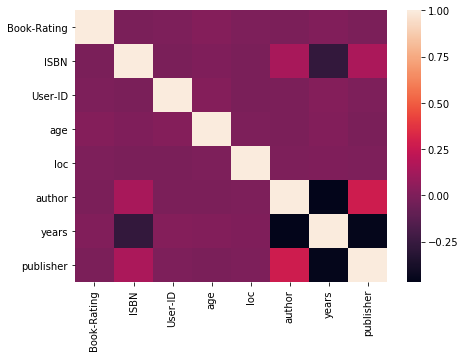

In [10]:
import seaborn as sns
plt.figure(figsize=[7,5])
sns.heatmap(ttt.corr())
plt.show()

In [11]:
def plot_importance(m, feature_list=['User-ID', 'ISBN', 'loc', 'age', 'author', 'publisher', 'years']):
    try:
        df = train.copy()
        df_plot = pd.DataFrame({'features': feature_list, 'importances': m.feature_importances_})
        df_plot = df_plot.sort_values('importances', ascending=False)

        plt.figure(figsize=[11,5])
        sns.barplot(x = df_plot.importances, y = df_plot.features)
        plt.title('Importances of Features Plot')
        plt.show()
    except KeyboardInterrupt:
        print ('KeyboardInterrupt')
    except:
        print ('no feature importance')

In [12]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
print(kf)

KFold(n_splits=5, random_state=None, shuffle=False)


In [13]:
# create 5 fold
train['foldID'] = 0
for i, (train_idx, val_idx) in enumerate(kf.split(train)):
    # train : val = 4 : 1
    train['foldID'][val_idx] = i+1

train.head()

,Book-Rating,ISBN,User-ID,age,loc,author,years,publisher,foldID
0,8.0,133745,6329,47.0,18959,41855,1992.0,560,1
1,10.0,21147,75160,0.0,9894,37869,2001.0,4132,1
2,8.0,13559,886,29.0,4962,62104,0.0,11567,1
3,10.0,31266,57887,0.0,15860,45272,1997.0,2678,1
4,9.0,80349,46556,45.0,8588,11258,2000.0,4553,1


In [14]:
from stack_model import FM, Surprise, XGBR, XGBC, Keras, nn
# retrieve by 'model' attribute, save before fit again

model_list = [nn(), Surprise(), FM(fm_ttt), XGBR(), XGBC(), Keras()]
model_name_list = [type(i).__name__ for i in model_list]

print (model_name_list)

['nn', 'Surprise', 'FM', 'XGBR', 'XGBC', 'Keras']


Using TensorFlow backend.


In [15]:
train_meta = train.copy()
test_meta = test.copy()
for i in model_list:
    name = type(i).__name__
    train_meta[name] = float('nan')
    test_meta[name] = float('nan')

test_meta.head()

,Book-Rating,ISBN,User-ID,age,loc,author,years,publisher,nn,Surprise,FM,XGBR,XGBC,Keras
260202,0.0,136726,12053,34.0,19915,7520,2001.0,343,NaN,NaN,NaN,NaN,NaN,NaN
260203,0.0,17136,10894,0.0,1711,61801,2003.0,4648,NaN,NaN,NaN,NaN,NaN,NaN
260204,0.0,102935,63113,0.0,3602,33296,2000.0,8248,NaN,NaN,NaN,NaN,NaN,NaN
260205,0.0,61845,23078,0.0,18596,55497,1997.0,9404,NaN,NaN,NaN,NaN,NaN,NaN
260206,0.0,8522,65227,0.0,14409,54293,1998.0,5226,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
feature_list=['User-ID', 'ISBN', 'loc', 'age', 'author', 'publisher', 'years']

for f in range(5):
    train_fold = train_meta[train_meta.foldID != f+1]
    val_fold = train_meta[train_meta.foldID == f+1]

    x_train, y_train = train_fold[feature_list], train_fold['Book-Rating']
    x_val, y_val = val_fold[feature_list], val_fold['Book-Rating']
    
    print ("fold", f+1, ', data length:', len(x_train))
    mean = 0
    
    for model, name in zip(model_list, model_name_list):
        print ('\t', name)
        #model.fit(x_train, y_train)
        model.fit(x_train, y_train, x_val, y_val)
        pred = model.predict(x_val)
        pred = np.round(pred)
        mae = MAE(pred, y_val)
        mean += mae
        print ("\t", 'validation score:', mae)
        train_meta[name][train_meta.foldID == f+1] = pred.astype(int)

    print ('mean validation score in ', f+1, 'fold:', mean/6)

train_meta.to_csv('stack/train_meta_.csv')

fold 1 , data length: 208161
	 nn
	 validation score: 1.22545685132876
	 Surprise
	 validation score: 1.2261486135931285
	 FM
	 validation score: 1.4320247497165697
	 XGBR
	 validation score: 1.2596030053227263
	 XGBC
	 validation score: 1.3723026075594242
	 Keras
	 validation score: 1.2469014815241828
mean validation score in  1 fold: 1.2937395515074652
fold 2 , data length: 208161
	 nn
	 validation score: 1.2234584270094733
	 Surprise
	 validation score: 1.2234584270094733
	 FM
	 validation score: 1.4412674621932706
	 XGBR
	 validation score: 1.2587383024922658
	 XGBC
	 validation score: 1.3633865605964528
	 Keras
	 validation score: 1.245268153955535
mean validation score in  2 fold: 1.2925962222094118
fold 3 , data length: 208162
	 nn
	 validation score: 1.2155265180630284
	 Surprise
	 validation score: 1.2137202152190623
	 FM
	 validation score: 1.5888931591083781
	 XGBR
	 validation score: 1.2515372790161414
	 XGBC
	 validation score: 1.366871637202152
	 Keras
	 validation score:

In [17]:
# performance on training set
pred = []
for i in model_name_list:
    print (i)
    p = train_meta[i].values
    print (MAE(p, train_meta['Book-Rating'].values))
    pred.append(p)
    
pred = np.round(np.mean(pred, 0))
print ('mean\n', MAE(pred, train_meta['Book-Rating'].values))

nn
1.2185225324939855
Surprise
1.218218922221966
FM
1.5280743422417968
XGBR
1.2538988939362494
XGBC
1.3677066279275332
Keras
1.2422387222235032
mean
 1.2428267269275408


In [18]:
# fit to all training data and fill in test meta
for model, name in zip(model_list, model_name_list):
    print (name)
    model.fit(train[feature_list], train['Book-Rating'], train[feature_list], train['Book-Rating'])
    pred = model.predict(test[feature_list])
    pred = np.round(pred)
    test_meta[name] = pred.astype(int)
test_meta.to_csv('stack/test_meta_.csv')

nn
Surprise
FM
XGBR
XGBC
Keras


In [19]:
# baseline
pred = []
for i in model_name_list:
    print (i)
    p = train_meta[i].values
    print (MAE(p, train_meta['Book-Rating'].values))
    pred.append(p)
    
pred = np.round(np.mean(pred, 0))
print ('mean\n', MAE(pred, train_meta['Book-Rating'].values))

nn
1.2185225324939855
Surprise
1.218218922221966
FM
1.5280743422417968
XGBR
1.2538988939362494
XGBC
1.3677066279275332
Keras
1.2422387222235032
mean
 1.2428267269275408


In [21]:
from sklearn.svm import LinearSVR
stack_feature_list = model_name_list
mean = 0
for f in range(5):
    train_fold = train_meta[train_meta.foldID != f+1]
    val_fold = train_meta[train_meta.foldID == f+1]

    x_train, y_train = train_fold[stack_feature_list], train_fold['Book-Rating']
    x_val, y_val = val_fold[stack_feature_list], val_fold['Book-Rating']
    
    print ("fold", f+1, ', data length:', len(x_train))
    
    model = LinearSVR()
    model.fit(x_train, y_train)
    pred = model.predict(x_val)
    pred = np.round(pred)
    mae = MAE(pred, y_val)
    mean += mae
    print ("\t", 'validation score:', mae)

print ('mean:', mean/5)

fold 1 , data length: 208161
	 validation score: 1.22155608078246
fold 2 , data length: 208161
	 validation score: 1.2178474664207068
fold 3 , data length: 208162
	 validation score: 1.390564950038432
fold 4 , data length: 208162
	 validation score: 1.4031514219830898
fold 5 , data length: 208162
	 validation score: 1.4046310530361261
mean: 1.3275501944521628


In [22]:
# create combinations of features
from itertools import combinations
all_combin = []
for k in range(1, len(model_name_list)):
    for j in combinations(model_name_list, k):
        all_combin.append(j)
print (all_combin)

[('nn',), ('Surprise',), ('FM',), ('XGBR',), ('XGBC',), ('Keras',), ('nn', 'Surprise'), ('nn', 'FM'), ('nn', 'XGBR'), ('nn', 'XGBC'), ('nn', 'Keras'), ('Surprise', 'FM'), ('Surprise', 'XGBR'), ('Surprise', 'XGBC'), ('Surprise', 'Keras'), ('FM', 'XGBR'), ('FM', 'XGBC'), ('FM', 'Keras'), ('XGBR', 'XGBC'), ('XGBR', 'Keras'), ('XGBC', 'Keras'), ('nn', 'Surprise', 'FM'), ('nn', 'Surprise', 'XGBR'), ('nn', 'Surprise', 'XGBC'), ('nn', 'Surprise', 'Keras'), ('nn', 'FM', 'XGBR'), ('nn', 'FM', 'XGBC'), ('nn', 'FM', 'Keras'), ('nn', 'XGBR', 'XGBC'), ('nn', 'XGBR', 'Keras'), ('nn', 'XGBC', 'Keras'), ('Surprise', 'FM', 'XGBR'), ('Surprise', 'FM', 'XGBC'), ('Surprise', 'FM', 'Keras'), ('Surprise', 'XGBR', 'XGBC'), ('Surprise', 'XGBR', 'Keras'), ('Surprise', 'XGBC', 'Keras'), ('FM', 'XGBR', 'XGBC'), ('FM', 'XGBR', 'Keras'), ('FM', 'XGBC', 'Keras'), ('XGBR', 'XGBC', 'Keras'), ('nn', 'Surprise', 'FM', 'XGBR'), ('nn', 'Surprise', 'FM', 'XGBC'), ('nn', 'Surprise', 'FM', 'Keras'), ('nn', 'Surprise', 'XGBR

In [23]:
from sklearn.metrics import make_scorer
def my_mae(ground, preds):
    return MAE(ground, np.round(preds))

In [24]:
# feature selection
best_score = 99
best_com = ""

for com in all_combin:
    
    stack_feature_list = [i for i in com]
    print (stack_feature_list)
    S = LinearSVR()
    parameters = {'C':[1]}

    grid = grid_search.GridSearchCV(S,
                            parameters,
                            cv = 5,
                            n_jobs = 5,
                            scoring = make_scorer(my_mae, greater_is_better=False),
                            verbose=True)

    grid.fit(train_meta[stack_feature_list], train_meta['Book-Rating'])

    if -grid.best_score_ < best_score:
        best_score = -grid.best_score_
        best_com = com
    print (-grid.best_score_ , best_score)
    
print (best_score, best_com)

['nn']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    4.8s remaining:    7.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    5.4s finished


1.2185225324939855 1.2185225324939855
['Surprise']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    4.8s remaining:    7.3s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    5.0s finished


1.218218922221966 1.218218922221966
['FM']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    3.6s remaining:    5.3s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    3.7s finished


1.434985126939839 1.218218922221966
['XGBR']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    4.0s remaining:    6.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.6s finished


1.2538988939362494 1.218218922221966
['XGBC']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    7.5s remaining:   11.2s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    8.5s finished


1.352218660886542 1.218218922221966
['Keras']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    4.3s remaining:    6.5s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    5.2s finished


1.2422387222235032 1.218218922221966
['nn', 'Surprise']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   11.7s remaining:   17.6s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   13.3s finished


1.218580180013989 1.218218922221966
['nn', 'FM']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    8.6s remaining:   12.9s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    9.5s finished


1.2185225324939855 1.218218922221966
['nn', 'XGBR']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   15.0s remaining:   22.5s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   15.6s finished


1.2185225324939855 1.218218922221966
['nn', 'XGBC']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   14.0s remaining:   20.9s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   15.3s finished


1.2185225324939855 1.218218922221966
['nn', 'Keras']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   12.8s remaining:   19.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   13.0s finished


1.2185225324939855 1.218218922221966
['Surprise', 'FM']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    8.3s remaining:   12.5s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    9.3s finished


1.218218922221966 1.218218922221966
['Surprise', 'XGBR']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   14.5s remaining:   21.8s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   15.2s finished


1.218218922221966 1.218218922221966
['Surprise', 'XGBC']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   12.7s remaining:   19.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   14.5s finished


1.218218922221966 1.218218922221966
['Surprise', 'Keras']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   10.0s remaining:   15.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   11.6s finished


1.218218922221966 1.218218922221966
['FM', 'XGBR']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    7.6s remaining:   11.5s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    8.3s finished


1.2538988939362494 1.218218922221966
['FM', 'XGBC']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   14.8s remaining:   22.2s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   16.2s finished


1.3522225040545421 1.218218922221966
['FM', 'Keras']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    9.0s remaining:   13.5s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    9.5s finished


1.2422387222235032 1.218218922221966
['XGBR', 'XGBC']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   12.0s remaining:   18.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   13.5s finished


1.2538988939362494 1.218218922221966
['XGBR', 'Keras']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   14.9s remaining:   22.4s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   16.1s finished


1.230797611086771 1.218218922221966
['XGBC', 'Keras']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   17.9s remaining:   26.9s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   18.7s finished


1.2422387222235032 1.218218922221966
['nn', 'Surprise', 'FM']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   17.2s remaining:   25.7s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   18.2s finished


1.218580180013989 1.218218922221966
['nn', 'Surprise', 'XGBR']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   25.2s remaining:   37.8s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   27.3s finished


1.218580180013989 1.218218922221966
['nn', 'Surprise', 'XGBC']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   23.2s remaining:   34.9s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   24.6s finished


1.218580180013989 1.218218922221966
['nn', 'Surprise', 'Keras']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   21.7s remaining:   32.5s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   22.4s finished


1.218580180013989 1.218218922221966
['nn', 'FM', 'XGBR']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   20.0s remaining:   29.9s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   21.2s finished


1.2185225324939855 1.218218922221966
['nn', 'FM', 'XGBC']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   20.2s remaining:   30.3s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   21.2s finished


1.2185225324939855 1.218218922221966
['nn', 'FM', 'Keras']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   17.4s remaining:   26.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   18.4s finished


1.2185225324939855 1.218218922221966
['nn', 'XGBR', 'XGBC']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   24.7s remaining:   37.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   26.6s finished


1.2185225324939855 1.218218922221966
['nn', 'XGBR', 'Keras']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   24.6s remaining:   36.9s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   25.6s finished


1.2185225324939855 1.218218922221966
['nn', 'XGBC', 'Keras']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   23.7s remaining:   35.6s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   24.8s finished


1.2185225324939855 1.218218922221966
['Surprise', 'FM', 'XGBR']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   20.0s remaining:   30.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   21.0s finished


1.218218922221966 1.218218922221966
['Surprise', 'FM', 'XGBC']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   19.6s remaining:   29.4s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   20.6s finished


1.218218922221966 1.218218922221966
['Surprise', 'FM', 'Keras']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   16.8s remaining:   25.2s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   17.5s finished


1.218218922221966 1.218218922221966
['Surprise', 'XGBR', 'XGBC']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   23.9s remaining:   35.9s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   25.7s finished


1.218218922221966 1.218218922221966
['Surprise', 'XGBR', 'Keras']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   22.5s remaining:   33.8s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   24.2s finished


1.218218922221966 1.218218922221966
['Surprise', 'XGBC', 'Keras']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   23.0s remaining:   34.6s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   25.1s finished


1.218218922221966 1.218218922221966
['FM', 'XGBR', 'XGBC']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   17.3s remaining:   25.9s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   18.7s finished


1.2538988939362494 1.218218922221966
['FM', 'XGBR', 'Keras']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   20.8s remaining:   31.2s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   21.8s finished


1.2302096063827335 1.218218922221966
['FM', 'XGBC', 'Keras']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   23.7s remaining:   35.5s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   25.2s finished


1.2422387222235032 1.218218922221966
['XGBR', 'XGBC', 'Keras']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   24.5s remaining:   36.7s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   25.4s finished


1.223015195886273 1.218218922221966
['nn', 'Surprise', 'FM', 'XGBR']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   29.5s remaining:   44.3s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   30.2s finished


1.2182150790539659 1.2182150790539659
['nn', 'Surprise', 'FM', 'XGBC']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   28.5s remaining:   42.7s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   29.2s finished


1.218580180013989 1.2182150790539659
['nn', 'Surprise', 'FM', 'Keras']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   27.4s remaining:   41.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   28.3s finished


1.218580180013989 1.2182150790539659
['nn', 'Surprise', 'XGBR', 'XGBC']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   28.5s remaining:   42.8s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   30.5s finished


1.2179960184779517 1.2179960184779517
['nn', 'Surprise', 'XGBR', 'Keras']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   29.9s remaining:   44.8s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   31.3s finished


1.2178499780939425 1.2178499780939425
['nn', 'Surprise', 'XGBC', 'Keras']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   29.1s remaining:   43.7s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   31.0s finished


1.218580180013989 1.2178499780939425
['nn', 'FM', 'XGBR', 'XGBC']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   28.5s remaining:   42.8s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   29.2s finished


1.2185225324939855 1.2178499780939425
['nn', 'FM', 'XGBR', 'Keras']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   29.6s remaining:   44.4s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   30.8s finished


1.2185225324939855 1.2178499780939425
['nn', 'FM', 'XGBC', 'Keras']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   30.2s remaining:   45.3s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   31.8s finished


1.2185225324939855 1.2178499780939425
['nn', 'XGBR', 'XGBC', 'Keras']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   30.2s remaining:   45.4s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   31.3s finished


1.2185225324939855 1.2178499780939425
['Surprise', 'FM', 'XGBR', 'XGBC']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   28.0s remaining:   42.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   29.4s finished


1.218218922221966 1.2178499780939425
['Surprise', 'FM', 'XGBR', 'Keras']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   28.3s remaining:   42.4s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   29.4s finished


1.218218922221966 1.2178499780939425
['Surprise', 'FM', 'XGBC', 'Keras']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   29.2s remaining:   43.9s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   30.2s finished


1.218218922221966 1.2178499780939425
['Surprise', 'XGBR', 'XGBC', 'Keras']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   29.6s remaining:   44.3s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   30.6s finished


1.218218922221966 1.2178499780939425
['FM', 'XGBR', 'XGBC', 'Keras']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   26.1s remaining:   39.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   27.6s finished


1.2281804136786036 1.2178499780939425
['nn', 'Surprise', 'FM', 'XGBR', 'XGBC']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   32.0s remaining:   48.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   33.3s finished


1.2171313056778965 1.2171313056778965
['nn', 'Surprise', 'FM', 'XGBR', 'Keras']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   32.9s remaining:   49.3s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   33.8s finished


1.215736235693807 1.215736235693807
['nn', 'Surprise', 'FM', 'XGBC', 'Keras']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   31.9s remaining:   47.9s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   33.1s finished


1.2182919424139707 1.215736235693807
['nn', 'Surprise', 'XGBR', 'XGBC', 'Keras']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   33.1s remaining:   49.6s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   34.6s finished


1.2157170198538059 1.2157170198538059
['nn', 'FM', 'XGBR', 'XGBC', 'Keras']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   32.4s remaining:   48.6s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   32.8s finished


1.2182535107339683 1.2157170198538059
['Surprise', 'FM', 'XGBR', 'XGBC', 'Keras']
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   31.3s remaining:   47.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   32.8s finished


1.2182150790539659 1.2157170198538059
1.2157170198538059 ('nn', 'Surprise', 'XGBR', 'XGBC', 'Keras')


In [25]:
# hyperparameter grid search
stack_feature_list = [i for i in best_com]
print (stack_feature_list)

S = LinearSVR()
parameters = {'C':[0.01, 0.1, 1, 10]}

grid = grid_search.GridSearchCV(S,
                        parameters,
                        cv = 5,
                        n_jobs = 5,
                        scoring = make_scorer(my_mae, greater_is_better=False),
                        verbose=True)

grid.fit(train_meta[stack_feature_list], train_meta['Book-Rating'])


print(grid.best_score_)
print(grid.best_params_)
print(grid.grid_scores_)

['nn', 'Surprise', 'XGBR', 'XGBC', 'Keras']
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:  1.6min finished


-1.2153480757257822
{'C': 1}
[mean: -1.21858, std: 0.00564, params: {'C': 0.01}, mean: -1.21858, std: 0.00564, params: {'C': 0.1}, mean: -1.21535, std: 0.00571, params: {'C': 1}, mean: -1.54964, std: 0.37925, params: {'C': 10}]


In [28]:
# fit on all training data
S = LinearSVR(**grid.best_params_)
S.fit(train_meta[stack_feature_list], train_meta['Book-Rating'])
plot_importance(S, stack_feature_list)
final_pred = S.predict(test_meta[stack_feature_list])

no feature importance


In [29]:
from sklearn.externals import joblib
joblib.dump(model, 'stack/stack1.pkl')

['stack/stack1.pkl']

In [30]:
# output final prediction
with open('stack/final1.csv', 'w') as f:
    for i in final_pred:
        print (int(round(i)), file=f)